In [23]:
%%capture
!pip install gdown

In [24]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/유진개인/To the Transformer/')
from multiclass_functions2 import * # my module import
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda


In [25]:
BATCH_SIZE = 64
LR = 2e-3 #초기 learning rate
LR_STEP = 3 #learning rate 유지 step
LR_GAMMA = 0.9 # decaying learning rate
LAMBDA = 1e-6
EPOCH = 10
criterion = nn.CrossEntropyLoss()

model_type = "CNN_deep"
dataset = "STL10"

new_model_train = True
hyuk_model_use = False # 여러분만의 모델 만들어서 사용하고 싶다면 False로
if hyuk_model_use:
    !gdown https://drive.google.com/uc?id=1zWiDHLk2IoTDp4m4u03aTCBBRdiICfil -O CNN_deep_STL10.pt
    !gdown https://drive.google.com/uc?id=1Ht8N_f_k763h-JQeJu-OfC9yJQ1XBwdr -O CNN_deep_history_STL10.pt
    save_model_path = f'{model_type}_{dataset}.pt'
    save_history_path = f'{model_type}_history_{dataset}.pt'
else:
    save_model_path = f'/content/drive/MyDrive/Colab Notebooks/results/{model_type}_{dataset}.pt'
    save_history_path = f'/content/drive/MyDrive/Colab Notebooks/results/{model_type}_history_{dataset}.pt'

In [26]:
transform = transforms.ToTensor()
train_DS = datasets.STL10(root = '/content/drive/MyDrive/Colab Notebooks/data', split="train", download=True, transform=transform)
NoT = int(0.8 * len(train_DS)) #numver of training
NoV = len(train_DS) - NoT #number of validation
train_DS, val_DS = torch.utils.data.random_split(train_DS, [NoT, NoV])
test_DS = datasets.STL10(root = '/content/drive/MyDrive/Colab Notebooks/data', split="test", download=True, transform=transform)

train_DL = torch.utils.data.DataLoader(train_DS, batch_size = BATCH_SIZE, shuffle = True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size = BATCH_SIZE, shuffle = True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size = BATCH_SIZE, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
print(len(train_DS))
print(len(val_DS))
print(len(test_DS))

4000
1000
8000


['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
torch.Size([64, 3, 96, 96])
monkey


tensor(7)

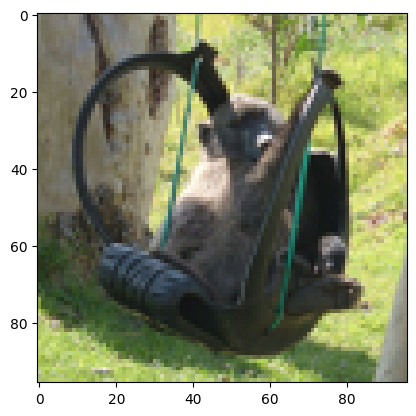

In [28]:
print(test_DS.classes)
x_batch, y_batch = next(iter(train_DL))

print(x_batch.shape)
plt.imshow(x_batch[0].permute(1,2,0))
print(test_DS.classes[y_batch[0]])
y_batch[0]


In [29]:
class CNN_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(3,32,3,padding=1, bias=False),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                                         nn.Conv2d(32,32,3,padding=1, bias=False),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU())
        self.Maxpool1 = nn.MaxPool2d(2)
        self.conv_block2 = nn.Sequential(nn.Conv2d(32,64,3,padding=1, bias=False),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1, bias=False),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1, bias=False),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU())
        self.Maxpool2 = nn.MaxPool2d(2)

        self.conv_block3 = nn.Sequential(nn.Conv2d(64,128,3,padding=1, bias=False),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1, bias=False),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1, bias=False),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU())
        self.Maxpool3 = nn.MaxPool2d(2)
        self.classifier = nn.Sequential(nn.Linear(128*12*12,512),
                                        nn.ReLU(),
                                        nn.Linear(512,10))

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.Maxpool1(x)
        x = self.conv_block2(x)
        x = self.Maxpool2(x)
        x = self.conv_block3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

In [30]:
model = eval(f"{model_type}().to(DEVICE)")
print(model)
x_batch, _ = next(iter(train_DL))
print(x_batch.shape)
print(model(x_batch.to(DEVICE)).shape)

CNN_deep(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [ ]:
if new_model_train:
    params = [p for p in model.parameters() if p.requires_grad] # for transfer learning
    optimizer = optim.Adam(params, lr = LR, weight_decay=LAMBDA) #weight decay -> weight regularization

    Train(model, train_DL, val_DL, criterion, optimizer,
          EPOCH, BATCH_SIZE,
          save_model_path, save_history_path,
          LR_STEP = LR_STEP, LR_GAMMA = LR_GAMMA)

Epoch: 1, current_LR = 0.002


train loss: 5.18596, val loss: 2.81563 
train acc: 12.2 %, val acc: 12.4 %, time: 9 s
--------------------
Epoch: 2, current_LR = 0.002


train loss: 2.44248, val loss: 2.06881 
train acc: 19.4 %, val acc: 23.9 %, time: 8 s
--------------------
Epoch: 3, current_LR = 0.002


train loss: 1.92921, val loss: 1.79764 
train acc: 30.1 %, val acc: 32.2 %, time: 8 s
--------------------
Epoch: 4, current_LR = 0.0018000000000000002


train loss: 1.70323, val loss: 1.67473 
train acc: 35.1 %, val acc: 37.5 %, time: 8 s
--------------------
Epoch: 5, current_LR = 0.0018000000000000002


train loss: 1.56469, val loss: 1.78468 
train acc: 40.8 %, val acc: 36.0 %, time: 7 s
--------------------
Epoch: 6, current_LR = 0.0018000000000000002


train loss: 1.47915, val loss: 1.55060 
train acc: 44.1 %, val acc: 42.4 %, time: 8 s
--------------------
Epoch: 7, current_LR = 0.0016200000000000001


train loss: 1.37459, val loss: 1.59681 
train acc: 48.1 %, val acc: 44.9 %, time: 7 s
--------------------
Epoch: 8, current_LR = 0.0016200000000000001


train loss: 1.30717, val loss: 1.50170 
train acc: 50.7 %, val acc: 44.7 %, time: 8 s
--------------------
Epoch: 9, current_LR = 0.0016200000000000001


train loss: 1.27343, val loss: 1.38747 
train acc: 52.0 %, val acc: 49.1 %, time: 7 s
--------------------
Epoch: 10, current_LR = 0.001458


train loss: 1.15981, val loss: 1.32888 
train acc: 56.5 %, val acc: 52.8 %, time: 8 s
--------------------


In [ ]:
loaded = torch.load(save_model_path, map_location=DEVICE)
load_model = loaded["model"]
ep = loaded["ep"]
optimizer = loaded["optimizer"]
scheduler = loaded["scheduler"]

loaded = torch.load(save_history_path, map_location=DEVICE)
loss_history = loaded["loss_history"]
acc_history = loaded["acc_history"]

print(ep)
print(optimizer)
print(scheduler.step_size)
print(scheduler.gamma)

9
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.002
    lr: 0.001458
    maximize: False
    weight_decay: 1e-06
)
3
0.9


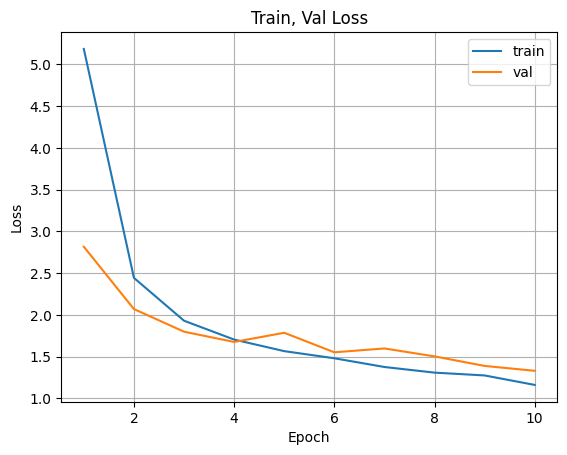

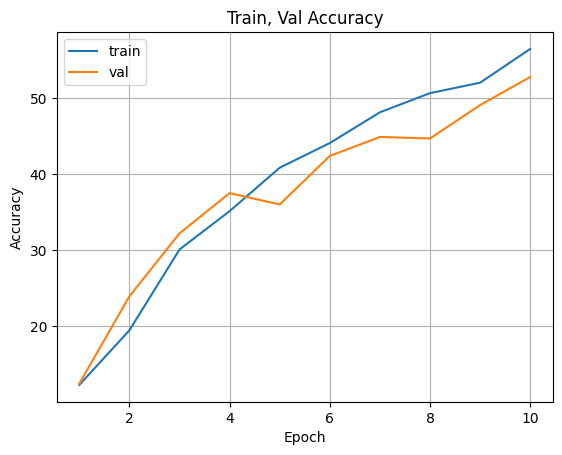

In [ ]:
plt.figure()
plt.plot(range(1,EPOCH+1), loss_history["train"], label="train")
plt.plot(range(1,EPOCH+1), loss_history["val"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.legend()
plt.grid()

plt.figure()
plt.plot(range(1,EPOCH+1), acc_history["train"], label="train")
plt.plot(range(1,EPOCH+1), acc_history["val"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train, Val Accuracy")
plt.legend()
plt.grid()

In [ ]:
Test(load_model, test_DL, criterion)
print(count_params(load_model))


Test loss: 1.341
Test accuracy: 4157/8000 (52.0 %)
9914986


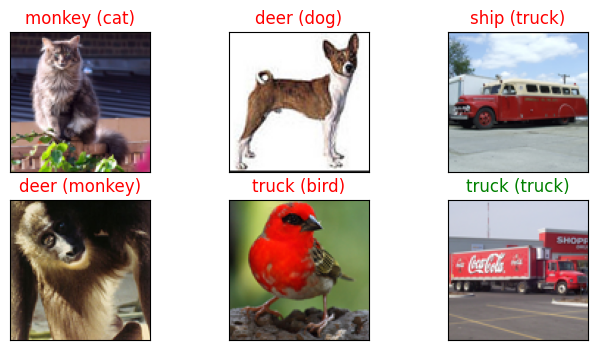

In [ ]:
Test_plot(load_model,test_DL)